In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 1. Функции

In [2]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Расчет метрики Hamming score, отражающей долю верно предсказанных
    элементов в объекте для задачи multi-label классификации
    '''
    acc_list = []
    
    # Цикл проходится по каждой паре таргет-предикт
    for i in range(y_true.shape[0]):
        # Для таргета и предикта создаются множества из индеков, на которых стоят единички
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i])[0])
        tmp_a = None
        
        # Если оба вектора состоят толька из ноликов, то предсказание абсолютно верно, и его скор = 1
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        
        # В противном случае количество верно предсказанных единичек делится на количество элементов
        # в объединенном множесте индексов единичек таргета и предикта. Таким образом, скор будет = 1
        # только в случае, если верно найдены все единички и нет ложных единичек
        else:
            tmp_a = len(set_true.intersection(set_pred)) / float(len(set_true.union(set_pred)))

        acc_list.append(tmp_a)
    return np.mean(acc_list)


def plot_matrix(y_true, y_pred, nrows, ncols):
    '''
    Отрисовка относительных матриц несоответствий для всех классов
    '''
    f, axes = plt.subplots(nrows, ncols, figsize=(25, 15))
    axes = axes.ravel()
    matrix = multilabel_confusion_matrix(y_true, y_pred)
    
    # Цикл проходится по всем классам
    for i in range(y_true.shape[1]):
        # В целевом классе (единички) определяется процентная доля верноположительных и ложноотрицательных
        # В нецелевом классе (нолики) определяется процентная доля верноотрицательных и ложноположительных
        percentages = matrix[i] / matrix[i].sum(axis=1).reshape(2, -1)
        
        disp = ConfusionMatrixDisplay(percentages, display_labels=[0, 1])
        disp.plot(ax=axes[i], cmap=plt.cm.Blues)
        disp.ax_.set_title(f'{y_test.columns[i]} ({str(y_test.iloc[:,i].sum())})')
        if i < (ncols * (nrows - 1)):
            disp.ax_.set_xlabel('')
        if i % ncols != 0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()

    
def evaluate(y_true, y_pred, save_file=False, filename='filename'):
    '''
    Выведение метрик для оценки качества работы модели.
    Опционально сохранение файла с предсказаниями модели
    '''
    print('Accuracy score:', round(accuracy_score(y_true, y_pred), 3))
    print('Hamming score:', round(hamming_score(y_true, y_pred), 3), '\n')
    print(classification_report(y_true, y_pred, target_names=y_test.columns, zero_division=0))
    if save_file:
        np.savetxt(filename, y_pred.astype(int), fmt='%i', delimiter=',')

# 2. Датасет

In [3]:
df_train = pd.read_csv('kinopoisk_train.csv')
df_test = pd.read_csv('kinopoisk_test.csv')

X_train, y_train = df_train['descr_lemmas'], df_train.drop('descr_lemmas', axis=1)
X_test, y_test = df_test['descr_lemmas'], df_test.drop('descr_lemmas', axis=1)

# 3. Модель на униграммах

In [4]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1)
    )),
    ('logreg', MultiOutputClassifier(
        estimator=LogisticRegression(
            max_iter=10000,
            class_weight='balanced',
            multi_class='multinomial',
            ))),
])

pipe.fit(X_train, y_train)

Wall time: 2min 5s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logreg',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    max_iter=10000,
                                                                    multi_class='multinomial')))])

### Оценка

In [5]:
y_pred = pipe.predict(X_test)
evaluate(y_test.to_numpy(), y_pred, save_file=True, filename='tfidf_logreg_ngram_1_1.csv')
joblib.dump(pipe, 'model_tfidf_logreg_ngram_1_1.pkl')

Accuracy score: 0.073
Hamming score: 0.415 

                 precision    recall  f1-score   support

          аниме       0.39      0.71      0.50       659
      биография       0.27      0.59      0.37       753
         боевик       0.46      0.73      0.56      2813
        вестерн       0.49      0.73      0.59       303
        военный       0.45      0.75      0.56       818
       детектив       0.35      0.66      0.46      1923
        детский       0.31      0.71      0.43       380
   для взрослых       0.15      0.22      0.18        72
 документальный       0.50      0.80      0.61      1267
          драма       0.66      0.70      0.68      9840
        история       0.30      0.66      0.41       941
        комедия       0.55      0.69      0.61      6042
короткометражка       0.38      0.69      0.49      1951
       криминал       0.47      0.73      0.57      2660
      мелодрама       0.47      0.68      0.56      4191
         музыка       0.35      0.60      

['model_tfidf_logreg_ngram_1_1.pkl']

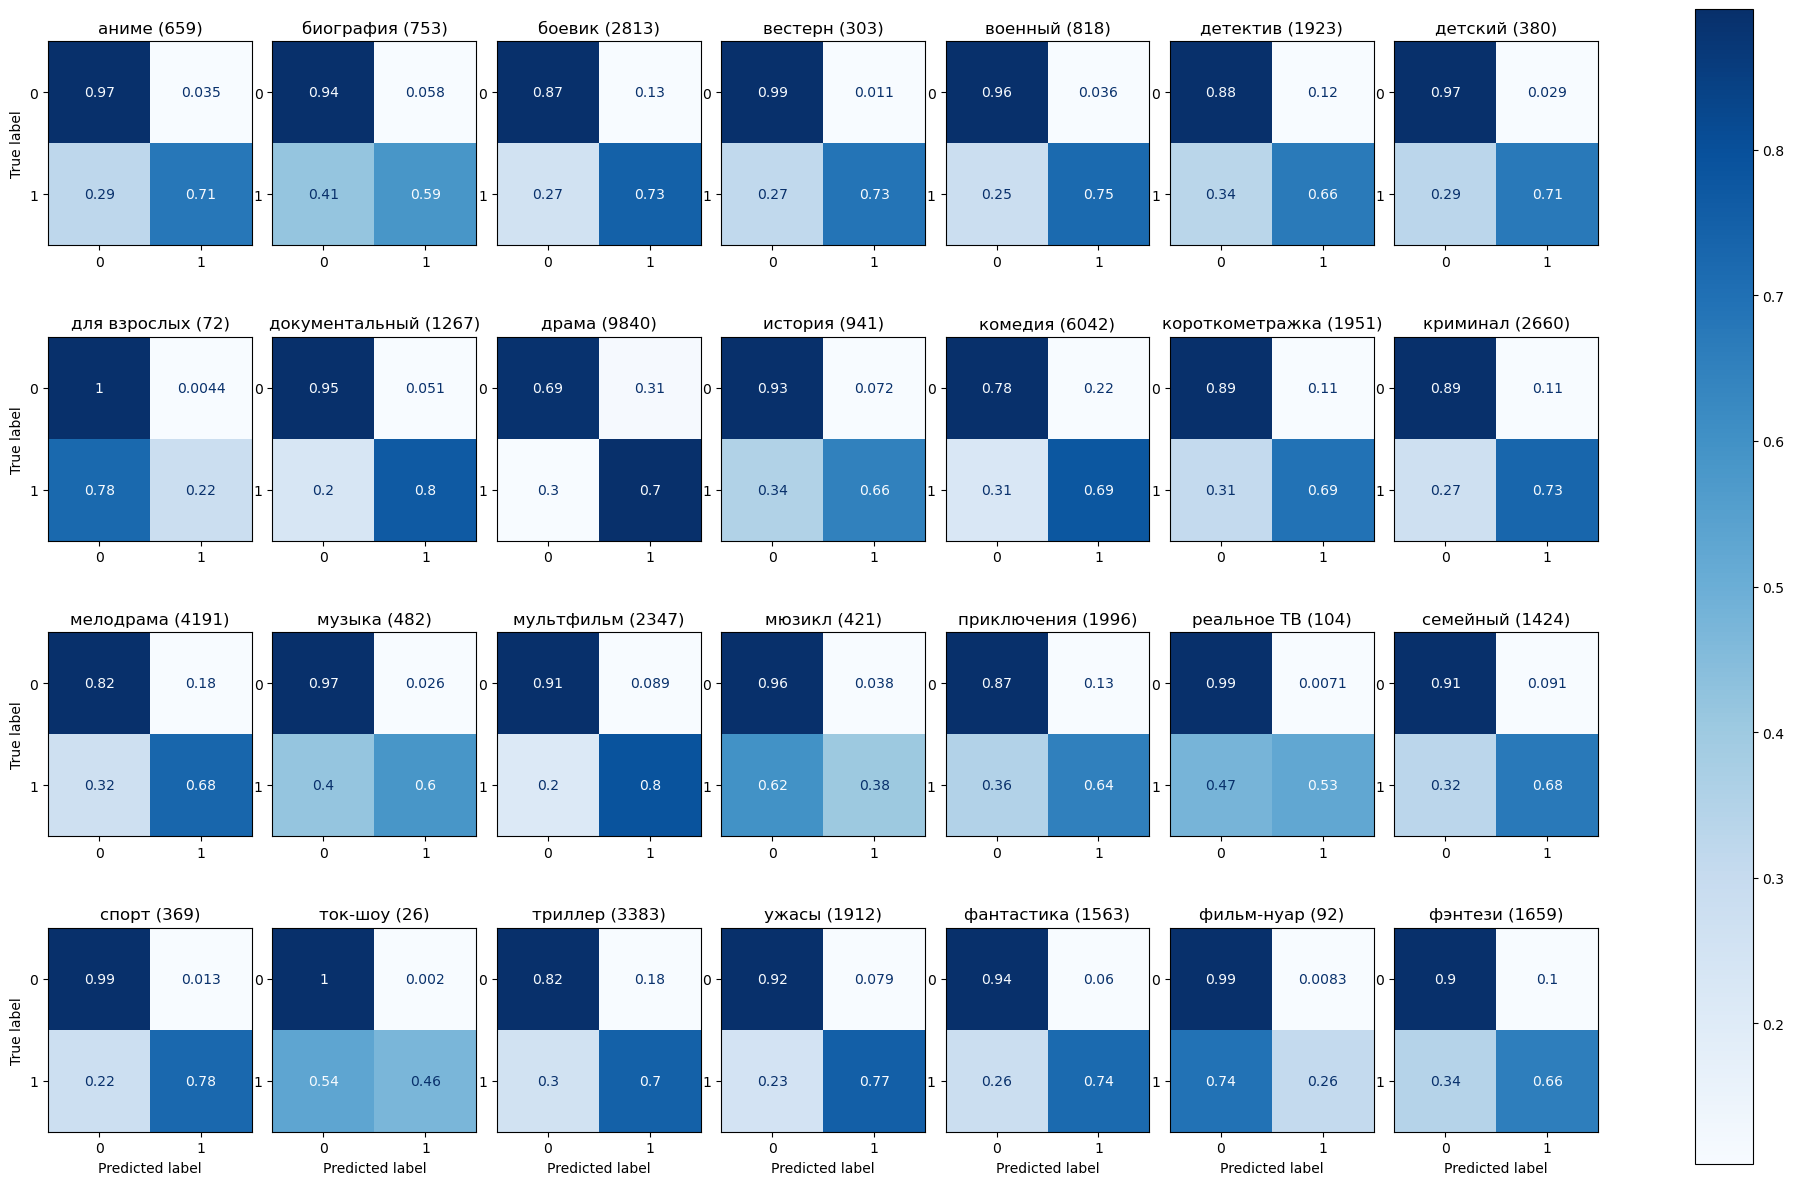

In [6]:
plot_matrix(y_test, y_pred, nrows=4, ncols=7)

# 4. Модель на униграммах + биграммах

In [7]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2)
    )),
    ('logreg', MultiOutputClassifier(
        estimator=LogisticRegression(
            max_iter=10000,
            class_weight='balanced',
            multi_class='multinomial',
            ))),
])

pipe.fit(X_train, y_train)

Wall time: 20min 40s


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('logreg',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    max_iter=10000,
                                                                    multi_class='multinomial')))])

### Оценка

In [8]:
y_pred = pipe.predict(X_test)
evaluate(y_test.to_numpy(), y_pred, save_file=True, filename='tfidf_logreg_ngram_1_2.csv')
joblib.dump(pipe, 'model_tfidf_logreg_ngram_1_2.pkl')

Accuracy score: 0.103
Hamming score: 0.443 

                 precision    recall  f1-score   support

          аниме       0.41      0.67      0.51       659
      биография       0.32      0.55      0.41       753
         боевик       0.47      0.73      0.57      2813
        вестерн       0.55      0.68      0.61       303
        военный       0.45      0.76      0.57       818
       детектив       0.39      0.63      0.48      1923
        детский       0.36      0.65      0.46       380
   для взрослых       0.24      0.14      0.18        72
 документальный       0.52      0.79      0.62      1267
          драма       0.66      0.73      0.69      9840
        история       0.33      0.65      0.43       941
        комедия       0.58      0.67      0.62      6042
короткометражка       0.58      0.50      0.54      1951
       криминал       0.50      0.72      0.59      2660
      мелодрама       0.48      0.69      0.57      4191
         музыка       0.40      0.56      

['model_tfidf_logreg_ngram_1_2.pkl']

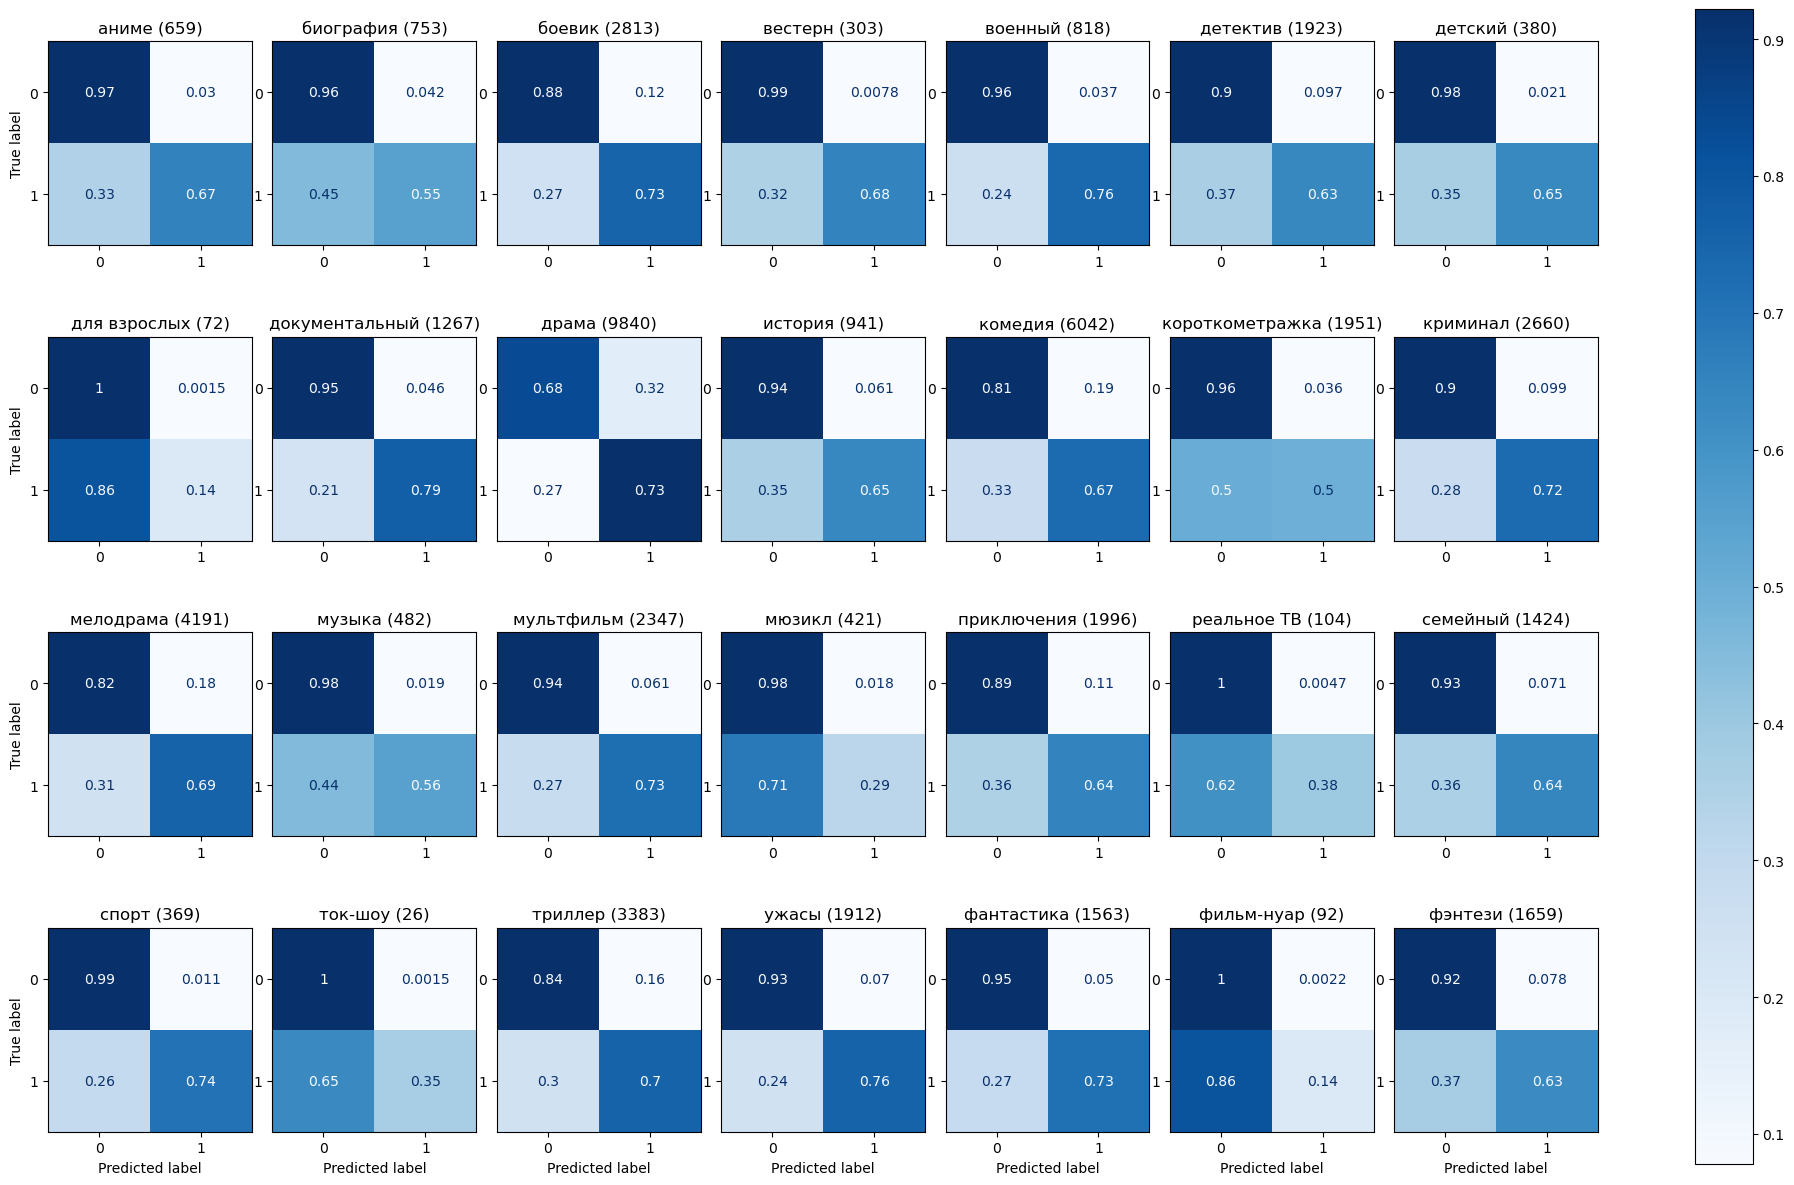

In [9]:
plot_matrix(y_test, y_pred, nrows=4, ncols=7)